# Problem formulation
Let $f(\theta, X) : \mathbb{R}^n \to \mathbb{R}$ be the loss function of parameters $\theta \in \mathbb{R}^n$ and the data $X \in \mathbb{R}^{s \times d}$. Let's also assume, that this function has the following structure (i.e., MSE, cross - entropy): 
$$
f(\theta, X) = \dfrac{1}{s}\sum\limits_{i=1}^s f(\theta, x_i) = \dfrac{1}{s}\sum\limits_{i=1}^s f_i(\theta),
$$
where $x_i$ - is the $i$-th line of the data array $X$ (one data point $x_i \in \mathbb{R}^d$). Therefore, the gradient of the function is calculated in such a manner: 
$$
\nabla_\theta f(\theta, X) = \dfrac{1}{s}\sum\limits_{i=1}^s \dfrac{\partial f(\theta, x_i)}{\partial \theta} = \dfrac{1}{s}\sum\limits_{i=1}^s \dfrac{\partial f_i(\theta)}{\partial \theta} = \dfrac{1}{s}\sum\limits_{i=1}^s g_i
$$ 

## Gradient Descent
The gradient descent with $h$ stepsize in form of the Euler's schem could be written as follows:

$$
\tag{GD}
\dfrac{d \theta}{d t} = - h \nabla_\theta f(\theta, X) = - h \dfrac{1}{s}\sum\limits_{i=1}^s g_i
$$

## Stochatic Gradient Descent (SGD)

In Stochastic Gradient Descent we split this sum of gradients into $N$ batches with size of $b$ in a following manner:

$$
- h \left( g_1 + g_2 + \ldots + g_s\right) = - h \left( \underbrace{g_1 + \ldots + g_b}_{v_1} + \underbrace{\ldots}_{v_2, \ldots v_{N-1}} + \underbrace{g_{s-b + 1} + \ldots + g_s}_{v_{N}}\right) = - h \left( v_1 + v_2 + \ldots + v_N\right)
$$
And in one *epoch* we do $N$ cheap steps, iterating $i$ from $1$ to $N$:
$$
\tag{SGD}
\dfrac{d \theta}{d t} = - h \dfrac{1}{b}v_i
$$

As soon as it can be considered as a splitting scheme in differential equations, we will try to compare first and second order splitting scheme via introducing *meta epoch* in two scenarios of doing stochastic gradient steps:

\begin{align*}
\tag{SGD1}
&\xrightarrow{v_1, v_2, \ldots, v_{N-1}, v_N}\;,\;\; \xrightarrow{v_1, v_2, \ldots, v_{N-1}, v_N} \\
\tag{SGD2}
&\xrightarrow{v_1, v_2, \ldots, v_{N-1}, v_N}\;,\;\; \xrightarrow{v_N, v_{N-1}, \ldots, v_2, v_1}
\end{align*}

## Stochastic Average Gradient
Suppose, we have Stochastic Average Gradient method, when each batch gradient $v_i$ is now parametrized by the number of epoch $t$: $v_i^t$ and we update only one batch gradient per iteration, but calculate gradient estimation using all the batch gradients (old and updated).

$$
\tag{SAG}
\dfrac{d \theta}{d t} = - h \dfrac{1}{s}\left(v_1^{t} + v_2^{t} + \ldots +  v_i^{t-1} + \ldots + v_N^{t-1}\right)
$$

As soon as it can be considered as a splitting scheme in differential equations, we will try to compare first and second order splitting scheme via introducing *meta epoch* in two scenarios of doing stochastic average gradient steps:

\begin{align*}
\tag{SAG1}
t-1 &\to t &\xrightarrow{v_1, v_2, \ldots, v_{N-1}, v_N}\;,\;\; \xrightarrow{v_1, v_2, \ldots, v_{N-1}, v_N} \\
\tag{SAG2}
t &\to t+1 &\xrightarrow{v_1, v_2, \ldots, v_{N-1}, v_N}\;,\;\; \xrightarrow{v_N, v_{N-1}, \ldots, v_2, v_1}
\end{align*}

## My Experiments with Stable SAG (MESSAG)
Classical approach of SAG requires to subtract old batch gradient every iteration, which in theory could lead to some issues with stability. We propose an approach to store the same amount of information and avoid any subtractions in the following way:
$$
grad_k = pregrad_k + v_k + postgrad_k
$$

# Experiments with LLS
We will test the algorithms on the linear least squares problem:
$$
f(\theta, X) = \dfrac{1}{s}\|X \theta - y\|^2_2, \quad X \in \mathbb{R}^{s \times n}, \theta \in \mathbb{R}^{n}, y \in \mathbb{R}^s
$$

$$
\nabla f(\theta, X) = \dfrac{1}{s}X^\top(X \theta - y)
$$

## SGD

In [0]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib.pyplot import *
%matplotlib inline
from tqdm import tqdm
 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
import torch.utils.data 

def plot_metrics(residuals1, residuals2,
                 gradients1, gradients2, 
                 fgradients1, fgradients2,
                 name = 'SGD', n=0,s=0,h=0):
    plt.figure(figsize=(16.0, 9.0))

    plt.subplot(2, 2, 1)
    plt.xlabel('Iterations')
    plt.ylabel('Function value on test set')
    plt.plot(residuals1, label = name+'1')
    plt.plot(residuals2, label = name+'2')
    plt.legend()

    plt.subplot(2, 2, 3)
    # plt.title('SGD, n = %d, s = %d, lr = %.3f, train 80 %%'%(n,s,h))
    plt.xlabel('Iterations')
    plt.ylabel('Gradient norm on test set')
    plt.semilogy(gradients1, label = name+'1')
    plt.semilogy(gradients2, label = name+'2')
    plt.legend()
    # plt.show()

    plt.subplot(2, 2, 2)
    # plt.title('SGD, n = %d, s = %d, lr = %.3f, train 80 %%'%(n,s,h))
    plt.xlabel('Iterations')
    plt.ylabel('Relative Gain in function value')
    plt.plot(((np.array(residuals1) - np.array(residuals2))/np.array(residuals2)))
    plt.axhline(y=0, color='r', linestyle='-')
    # plt.legend()
    # plt.show()

    plt.subplot(2, 2, 4)
    plt.xlabel('Iterations')
    plt.ylabel('Full gradient norm')
    plt.semilogy(fgradients1, label = name+'1')
    plt.semilogy(fgradients2, label = name+'2')
    plt.legend()


    plt.tight_layout()
    plt.suptitle(name+', n = %d, s = %d, lr = %.3f, train 80 %%'%(n,s,h))
    plt.subplots_adjust(top=0.88)
    plt.savefig(name+'_%.3f.pdf'%h)
    plt.show()

def plot_metrics_net(loss_train1, loss_train2,
                 loss_test1, loss_test2, 
                 bgradients1, bgradients2, h,
                 name = 'SGD', final_train_accuracy1=0, final_test_accuracy1=0,
                               final_train_accuracy2=0, final_test_accuracy2=0):
    plt.figure(figsize=(16.0, 9.0))

    plt.subplot(2, 2, 1)
    plt.xlabel('Iterations')
    plt.ylabel('Train loss')
    plt.plot(loss_train1, label = name+'1')
    plt.plot(loss_train2, label = name+'2')
    plt.legend()

    plt.subplot(2, 2, 2)
    # plt.title('SGD, n = %d, s = %d, lr = %.3f, train 80 %%'%(n,s,h))
    plt.xlabel('Epochs')
    plt.ylabel('Test loss')
    plt.semilogy(loss_test1, label = name+'1')
    plt.semilogy(loss_test2, label = name+'2')
    plt.legend()
    # plt.show()

    plt.subplot(2, 2, 3)
    # plt.title('SGD, n = %d, s = %d, lr = %.3f, train 80 %%'%(n,s,h))
    plt.xlabel('Epochs')
    plt.ylabel('Relative Gain in test loss')
    plt.plot(((np.array(loss_test1) - np.array(loss_test2))/np.array(loss_test2)))
    plt.axhline(y=0, color='r', linestyle='-')
    # plt.legend()
    # plt.show()

    plt.subplot(2, 2, 4)
    plt.xlabel('Iterations')
    plt.ylabel('Batch gradient norm')
    plt.semilogy(bgradients1, label = name+'1')
    plt.semilogy(bgradients2, label = name+'2')
    plt.legend()


    plt.tight_layout()
    if (final_train_accuracy1 == 0) or (final_test_accuracy1 == 0):
        plt.suptitle(name)
    else:
        plt.suptitle(name+',\n I: Train Acc %d %%, Test Acc %d %%, \n II: Train Acc %d %%, Test Acc %d %% '%(100*final_train_accuracy1, 100*final_test_accuracy1, 100*final_train_accuracy2, 100*final_test_accuracy2))
    plt.subplots_adjust(top=0.88)
    plt.savefig(name+'_%.3f.pdf'%h)
    plt.show()

In [0]:
# Matrix Generation
n = 100
s = 1000
X = torch.randn(s, n)
X, _ = torch.qr(X)
sv = 0.8**torch.arange(n, dtype=torch.float)
X = X@torch.diag(sv)

In [0]:
# Model definition
theta_clean = torch.ones(n)
y = X@theta_clean + 5e-1*torch.randn(s) # right-hand side
theta_0 = torch.randn(n, requires_grad=False)
theta_true = np.linalg.lstsq(X, y, rcond=-1)[0]
theta_true = torch.FloatTensor(theta_true)

In [0]:
# Parameters
b = 50   # batch size
N = 20   # total number of batches. should be equal to the s/b
h = 1  # step size
n_meta_epochs = 50

# Train test splitting
full_dataset = torch.utils.data.TensorDataset(X, y)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
X_train, y_train = X[train_dataset.indices], y[train_dataset.indices]
X_test, y_test = X[test_dataset.indices], y[test_dataset.indices]

In [0]:
# SGD1

N_train = int(train_size/len(full_dataset)*N)   # Number of training batches
N_test  = int(test_size/len(full_dataset)*N)    # Number of test batches
s_train = b*N_train                             # Number of training points
s_test  = b*N_test                              # Number of test points
criterion = torch.nn.MSELoss()
theta = theta_0.detach().clone().requires_grad_(True) #Starting

Xs = torch.zeros((N_train,b,n),requires_grad=False)
ys = torch.zeros((N_train,b),requires_grad=False)

for i in range(N_train):
    Xs[i] = X_train[b*i:b*(i+1), :] 
    ys[i] = y_train[b*i:b*(i+1)]
    
residuals1  = []
gradients1  = []
fgradients1 = []

for j in tqdm(range(n_meta_epochs)):
    for i in range(N_train):
        pred = Xs[i]@theta
        loss = criterion(pred, ys[i])
        v = torch.autograd.grad(loss, theta)

        # Gradient step
        theta.data = theta.data - h*v[0].data

#         # Norm of the gradient
#         gradients1.append(1/s_test*torch.norm(X_test.t()@(X_test@theta - y_test)))
#         # Norm of the full gradient
#         fgradients1.append(1/s*torch.norm(X.t()@(X@theta - y)))
#         # Residual
#         residuals1.append(1/s_test*torch.norm(X_test@theta - y_test)**2)

    for i in range(N_train):
        pred = Xs[i]@theta
        loss = criterion(pred, ys[i])
        v = torch.autograd.grad(loss, theta)

        # Gradient step
        theta.data = theta.data - h*v[0].data

    # Norm of the gradient
    gradients1.append(1/s_test*torch.norm(X_test.t()@(X_test@theta - y_test)))
    # Norm of the full gradient
    fgradients1.append(1/s*torch.norm(X.t()@(X@theta - y)))
    # Residual
    residuals1.append(1/s_test*torch.norm(X_test@theta - y_test)**2)

100%|██████████| 50/50 [00:00<00:00, 187.07it/s]


In [0]:
# SGD2

N_train = int(train_size/len(full_dataset)*N)   # Number of training batches
N_test  = int(test_size/len(full_dataset)*N)    # Number of test batches
s_train = b*N_train                             # Number of training points
s_test  = b*N_test                              # Number of test points
criterion = torch.nn.MSELoss()
theta = theta_0.detach().clone().requires_grad_(True) #Starting

Xs = torch.zeros((N_train,b,n),requires_grad=False)
ys = torch.zeros((N_train,b),requires_grad=False)

for i in range(N_train):
    Xs[i] = X_train[b*i:b*(i+1), :] 
    ys[i] = y_train[b*i:b*(i+1)]
    
residuals2 = []
gradients2 = []
fgradients2 = []

for j in tqdm(range(n_meta_epochs)):
    for i in range(N_train):
        pred = Xs[i]@theta
        loss = criterion(pred, ys[i])
        v = torch.autograd.grad(loss, theta)

        # Gradient step
        theta.data = theta.data - h*v[0].data

#         # Norm of the gradient
#         gradients2.append(1/s_test*torch.norm(X_test.t()@(X_test@theta - y_test)))
#         # Norm of the full gradient
#         fgradients2.append(1/s*torch.norm(X.t()@(X@theta - y)))
#         # Residual
#         residuals2.append(1/s_test*torch.norm(X_test@theta - y_test)**2)

    for k in range(N_train):
        i = N_train-(k+1)   # KEY DIFFERENCE
        pred = Xs[i]@theta
        loss = criterion(pred, ys[i])
        v = torch.autograd.grad(loss, theta)

        # Gradient step
        theta.data = theta.data - h*v[0].data

    # Norm of the gradient
    gradients2.append(1/s_test*torch.norm(X_test.t()@(X_test@theta - y_test)))
    # Norm of the full gradient
    fgradients2.append(1/s*torch.norm(X.t()@(X@theta - y)))
    # Residual
    residuals2.append(1/s_test*torch.norm(X_test@theta - y_test)**2)

100%|██████████| 50/50 [00:00<00:00, 231.03it/s]


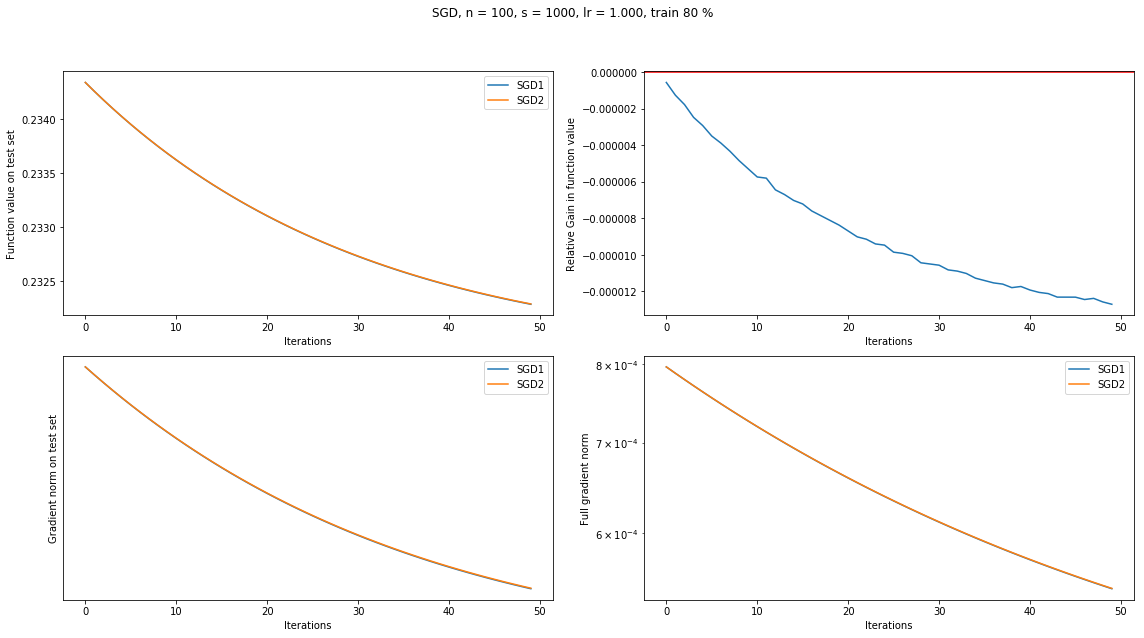

In [0]:
plot_metrics(residuals1, residuals2,
             gradients1, gradients2,
             fgradients1, fgradients2,
             'SGD', n,s,h)

## SAG

In [0]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib.pyplot import *
%matplotlib inline
from tqdm import tqdm
 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
import torch.utils.data 

n = 100
s = 1000
X = torch.randn(s, n)
X, _ = torch.qr(X)
sv = 0.8**torch.arange(n, dtype=torch.float)
X = X@torch.diag(sv)

theta_clean = torch.ones(n)
y = X@theta_clean + 5e-1*torch.randn(s) # right-hand side
theta_0 = torch.randn(n, requires_grad=False)
theta_true = np.linalg.lstsq(X, y, rcond=-1)[0]
theta_true = torch.FloatTensor(theta_true)

b = 50   # batch size
N = 20   # total number of batches. should be equal to the s/b
h = 5    # step size
n_meta_epochs = 8

# Train test splitting
full_dataset = torch.utils.data.TensorDataset(X, y)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
X_train, y_train = X[train_dataset.indices], y[train_dataset.indices]
X_test, y_test = X[test_dataset.indices], y[test_dataset.indices]

In [0]:
# SAG1

N_train = int(train_size/len(full_dataset)*N)   # Number of training batches
N_test  = int(test_size/len(full_dataset)*N)    # Number of test batches
s_train = b*N_train                             # Number of training points
s_test  = b*N_test                              # Number of test points
criterion = torch.nn.MSELoss()
theta = theta_0.detach().clone().requires_grad_(True) #Starting

Xs      = torch.zeros((N_train,b,n),requires_grad=False)
ys      = torch.zeros((N_train,b),requires_grad=False)
v_hist  = torch.zeros((N_train,n),requires_grad=False)
av_grad = torch.zeros((n),requires_grad=False)

for i in range(N_train):
    Xs[i] = X_train[b*i:b*(i+1), :] 
    ys[i] = y_train[b*i:b*(i+1)]
    
residuals1 = []
gradients1 = []
fgradients1 = []
for j in tqdm(range(n_meta_epochs)):
    for i in range(N_train):
        pred = Xs[i]@theta
        loss = criterion(pred, ys[i])
        
        av_grad   = av_grad - v_hist[i]
        v_hist[i] = b*torch.autograd.grad(loss, theta)[0]
        av_grad   = av_grad + v_hist[i]
        grad      = (1/s_train)*av_grad

        # Gradient step
        theta.data = theta.data - h*grad.data
        
        # Norm of the gradient
        gradients1.append(1/s_test*torch.norm(X_test.t()@(X_test@theta - y_test)))
        # Norm of the full gradient
        fgradients1.append(1/s*torch.norm(X.t()@(X@theta - y)))
        # Residual
        residuals1.append(1/s_test*torch.norm(X_test@theta - y_test)**2)

    for i in range(N_train):
        pred = Xs[i]@theta
        loss = criterion(pred, ys[i])
        
        av_grad   = av_grad - v_hist[i]
        v_hist[i] = b*torch.autograd.grad(loss, theta)[0]
        av_grad   = av_grad + v_hist[i]
        grad      = (1/s_train)*av_grad

        # Gradient step
        theta.data = theta.data - h*grad.data

        # Norm of the gradient
        gradients1.append(1/s_test*torch.norm(X_test.t()@(X_test@theta - y_test)))
        # Norm of the full gradient
        fgradients1.append(1/s*torch.norm(X.t()@(X@theta - y)))
        # Residual
        residuals1.append(1/s_test*torch.norm(X_test@theta - y_test)**2)

100%|██████████| 8/8 [00:00<00:00, 74.27it/s]


In [0]:
# SAG2

N_train = int(train_size/len(full_dataset)*N)   # Number of training batches
N_test  = int(test_size/len(full_dataset)*N)    # Number of test batches
s_train = b*N_train                             # Number of training points
s_test  = b*N_test                              # Number of test points
criterion = torch.nn.MSELoss()
theta = theta_0.detach().clone().requires_grad_(True) #Starting

Xs     = torch.zeros((N_train,b,n),requires_grad=False)
ys     = torch.zeros((N_train,b),requires_grad=False)
v_hist = torch.zeros((N_train,n),requires_grad=False)
av_grad = torch.zeros((n),requires_grad=False)

for i in range(N_train):
    Xs[i] = X_train[b*i:b*(i+1), :] 
    ys[i] = y_train[b*i:b*(i+1)]
    
residuals2  = []
gradients2  = []
fgradients2 = []

for j in tqdm(range(n_meta_epochs)):
    for i in range(N_train):
        pred = Xs[i]@theta
        loss = criterion(pred, ys[i])
        av_grad   = av_grad - v_hist[i]
        v_hist[i] = b*torch.autograd.grad(loss, theta)[0]
        av_grad   = av_grad + v_hist[i]
        grad      = (1/s_train)*av_grad

        # Gradient step
        theta.data = theta.data - h*grad.data
        
        # Norm of the gradient
        gradients2.append(1/s_test*torch.norm(X_test.t()@(X_test@theta - y_test)))
        # Norm of the full gradient
        fgradients2.append(1/s*torch.norm(X.t()@(X@theta - y)))
        # Residual
        residuals2.append(1/s_test*torch.norm(X_test@theta - y_test)**2)

    for k in range(N_train):
        i = N_train-(k+1)   # KEY DIFFERENCE
        pred = Xs[i]@theta
        loss = criterion(pred, ys[i])
        av_grad   = av_grad - v_hist[i]
        v_hist[i] = b*torch.autograd.grad(loss, theta)[0]
        av_grad   = av_grad + v_hist[i]
        grad      = (1/s_train)*av_grad

        # Gradient step
        theta.data = theta.data - h*grad.data

        # Norm of the gradient
        gradients2.append(1/s_test*torch.norm(X_test.t()@(X_test@theta - y_test)))
        # Norm of the full gradient
        fgradients2.append(1/s*torch.norm(X.t()@(X@theta - y)))
        # Residual
        residuals2.append(1/s_test*torch.norm(X_test@theta - y_test)**2)

100%|██████████| 8/8 [00:00<00:00, 83.56it/s]


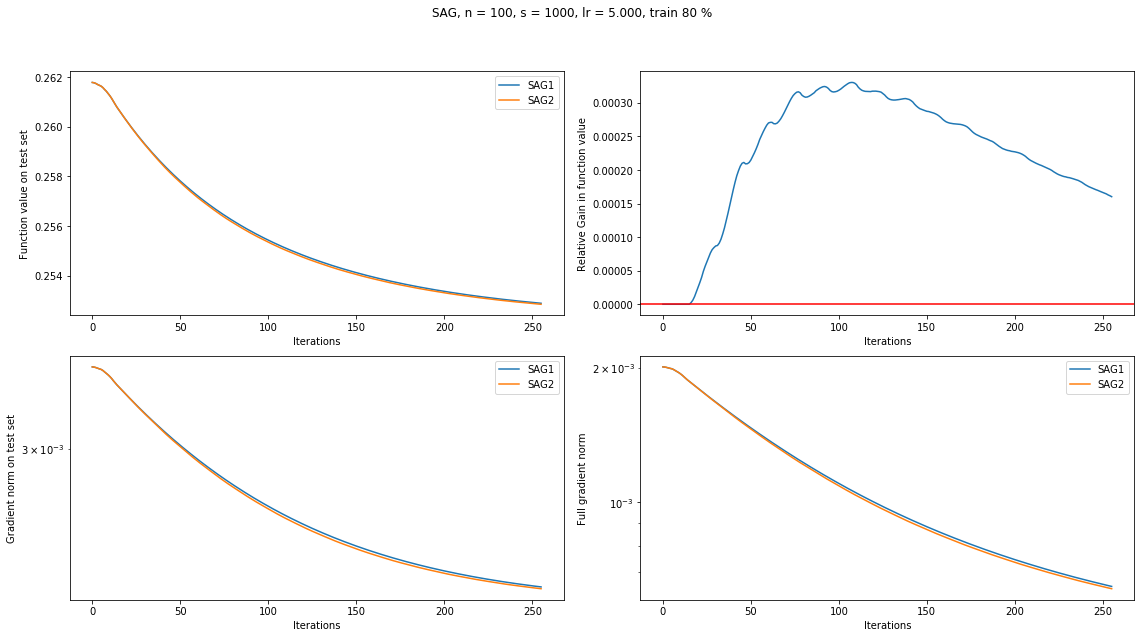

In [0]:
plot_metrics(residuals1, residuals2,
             gradients1, gradients2,
             fgradients1, fgradients2,
             'SAG', n,s,h)

## MESAG

In [0]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib.pyplot import *
%matplotlib inline
from tqdm import tqdm
 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
import torch.utils.data 

n = 100
s = 1000
X = torch.randn(s, n)
X, _ = torch.qr(X)
sv = 0.8**torch.arange(n, dtype=torch.float)
X = X@torch.diag(sv)

theta_clean = torch.ones(n)
y = X@theta_clean + 5e-1*torch.randn(s) # right-hand side
theta_0 = torch.randn(n, requires_grad=False)
theta_true = np.linalg.lstsq(X, y, rcond=-1)[0]
theta_true = torch.FloatTensor(theta_true)

b = 20   # batch size
N = 50   # total number of batches. should be equal to the s/b
h = 1  # step size
n_meta_epochs = 12
hs = [h for i in range(n_meta_epochs)]


# Train test splitting
full_dataset = torch.utils.data.TensorDataset(X, y)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
X_train, y_train = X[train_dataset.indices], y[train_dataset.indices]
X_test, y_test = X[test_dataset.indices], y[test_dataset.indices]

In [0]:
# SAG

N_train = int(train_size/len(full_dataset)*N)   # Number of training batches
N_test  = int(test_size/len(full_dataset)*N)    # Number of test batches
s_train = b*N_train                             # Number of training points
s_test  = b*N_test                              # Number of test points
criterion = torch.nn.MSELoss()
theta = theta_0.detach().clone().requires_grad_(True) #Starting

Xs     = torch.zeros((N_train,b,n),requires_grad=False)
ys     = torch.zeros((N_train,b),requires_grad=False)
v_hist = torch.zeros((N_train,n),requires_grad=False)
av_grad = torch.zeros((n),requires_grad=False)

for i in range(N_train):
    Xs[i] = X_train[b*i:b*(i+1), :] 
    ys[i] = y_train[b*i:b*(i+1)]
    
residuals1 = []
gradients1 = []
fgradients1 = []

for j in tqdm(range(n_meta_epochs)):
    h = hs[j]
    for i in range(N_train):
        pred = Xs[i]@theta
        loss = criterion(pred, ys[i])
        
        av_grad   = av_grad - v_hist[i]
        v_hist[i] = b*torch.autograd.grad(loss, theta)[0]
        av_grad   = av_grad + v_hist[i]
        grad      = (1/s_train)*av_grad

        # Gradient step
        theta.data = theta.data - h*grad.data
        
        # Norm of the gradient
        gradients1.append(1/s_test*torch.norm(X_test.t()@(X_test@theta - y_test)))
        # Norm of the full gradient
        fgradients1.append(1/s*torch.norm(X.t()@(X@theta - y)))
        # Residual
        residuals1.append(1/s_test*torch.norm(X_test@theta - y_test)**2)

    for i in range(N_train):
        pred = Xs[i]@theta
        loss = criterion(pred, ys[i])
        
        av_grad   = av_grad - v_hist[i]
        v_hist[i] = b*torch.autograd.grad(loss, theta)[0]
        av_grad   = av_grad + v_hist[i]
        grad      = (1/s_train)*av_grad

        # Gradient step
        theta.data = theta.data - h*grad.data

        # Norm of the gradient
        gradients1.append(1/s_test*torch.norm(X_test.t()@(X_test@theta - y_test)))
        # Norm of the full gradient
        fgradients1.append(1/s*torch.norm(X.t()@(X@theta - y)))
        # Residual
        residuals1.append(1/s_test*torch.norm(X_test@theta - y_test)**2)

100%|██████████| 12/12 [00:00<00:00, 32.11it/s]


In [0]:
# MESAG

N_train = int(train_size/len(full_dataset)*N)   # Number of training batches
N_test  = int(test_size/len(full_dataset)*N)    # Number of test batches
s_train = b*N_train                             # Number of training points
s_test  = b*N_test                              # Number of test points
criterion = torch.nn.MSELoss()
theta = theta_0.detach().clone().requires_grad_(True) #Starting

Xs        = torch.zeros((N_train,b,n),requires_grad=False)
ys        = torch.zeros((N_train,b),requires_grad=False)
pregrads  = torch.zeros((N_train,n),requires_grad=False)
postgrads = torch.zeros((N_train,n),requires_grad=False)

for i in range(N_train):
    Xs[i] = X_train[b*i:b*(i+1), :] 
    ys[i] = y_train[b*i:b*(i+1)]
    
residuals2  = []
gradients2  = []
fgradients2 = []
pregrad     = torch.zeros((n),requires_grad=False)
postgrad    = torch.zeros((n),requires_grad=False)

for j in tqdm(range(n_meta_epochs)):
    h = hs[j]
    for i in range(N_train):        
        pred = Xs[i]@theta
        loss = criterion(pred, ys[i])
        
        bgrad    = b*torch.autograd.grad(loss, theta)[0]
        pregrad  = pregrads[i]
        postgrad = postgrads[i]
        grad = 1/s_train*(pregrad + bgrad + postgrad)

        # Gradient step
        theta.data = theta.data - h*grad.data
        
         # Norm of the gradient
        gradients2.append(1/s_test*torch.norm(X_test.t()@(X_test@theta - y_test)))
        # Norm of the full gradient
        fgradients2.append(1/s*torch.norm(X.t()@(X@theta - y)))
        # Residual
        residuals2.append(1/s_test*torch.norm(X_test@theta - y_test)**2)
        
        if i+1 == N_train:
            continue
        pregrads[i+1] = pregrads[i] + bgrad
        
    for k in range(N_train):
        i = N_train-(k+1)
        pred = Xs[i]@theta
        loss = criterion(pred, ys[i])
        
        bgrad    = b*torch.autograd.grad(loss, theta)[0]
        pregrad  = pregrads[i]
        postgrad = postgrads[i]
        grad = 1/s_train*(pregrad + bgrad + postgrad)

        # Gradient step
        theta.data = theta.data - h*grad.data 

        # Norm of the gradient
        gradients2.append(1/s_test*torch.norm(X_test.t()@(X_test@theta - y_test)))
        # Norm of the full gradient
        fgradients2.append(1/s*torch.norm(X.t()@(X@theta - y)))
        # Residual
        residuals2.append(1/s_test*torch.norm(X_test@theta - y_test)**2)
        
        if k+1 == N_train:
            continue
        postgrads[i-1] = postgrads[i] + bgrad

100%|██████████| 12/12 [00:00<00:00, 29.78it/s]


ValueError: operands could not be broadcast together with shapes (3,) (50,) 

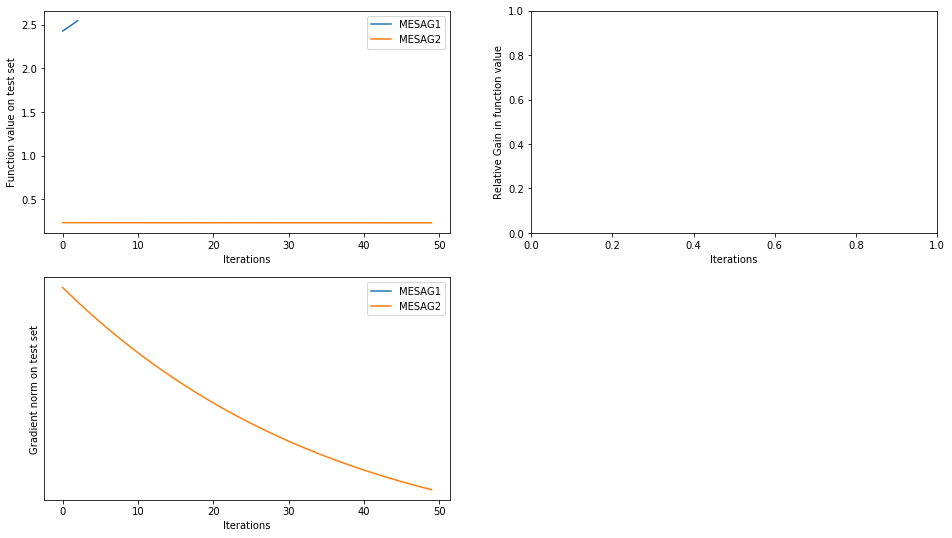

In [0]:
plot_metrics(residuals1, residuals2,
             gradients1, gradients2,
             fgradients1, fgradients2,
             'MESAG', n,s,h)

In [0]:
# theoretical stepsize of GD
s_train/torch.norm(X_train.transpose(0,1)@X_train)

tensor(763.5724)

Text(0.5, 1.0, 'SVD')

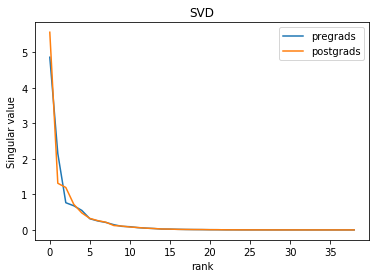

In [0]:
# Ranks
u,s,v = np.linalg.svd(pregrads[1:])
plt.plot(s, label = 'pregrads')
u,s,v = np.linalg.svd(postgrads[:-1])
plt.plot(s, label = 'postgrads')
plt.xlabel('rank')
plt.ylabel('Singular value')
plt.legend()
plt.title('SVD')

# Experiments with Fashion MNIST and simple CNN

## SGD

In [0]:
import torch 
import numpy as np
# torch.cuda.set_device(0)
print('Working on GPU ',torch.cuda.current_device())
import torch.nn as nn
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
# from matplotlib.pyplot import *
%matplotlib inline
from tqdm import tqdm

n = 784
s = 70000

b = 50   # batch size
N = 1400   # total number of batches. should be equal to the s/b
h = 0.000001  # step size
n_meta_epochs = 10
hs = np.array([h for i in range(n_meta_epochs)])*np.linspace(1,0.001, n_meta_epochs)

# Download and load the training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True)
X_train = trainset.train_data.to(dtype=torch.float)/255
y_train = trainset.train_labels
X_train.resize_(len(X_train), 1, *X_train[0].shape)
y_train.view(-1).long()

shuffling = torch.randperm(len(y_train))
X_train = X_train[shuffling]
y_train = y_train[shuffling]

# Download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False)
X_test = testset.test_data.to(dtype=torch.float)/255
y_test = testset.test_labels
X_test.resize_(len(X_test), 1, *X_test[0].shape)
y_test.view(-1).long()

shuffling = torch.randperm(len(y_test))
X_test = X_test[shuffling].cuda()
y_test = y_test[shuffling]

N_train = int(len(y_train)/(len(y_train) + len(y_test))*N)   # Number of training batches
N_test  = int(len(y_test)/(len(y_train)  + len(y_test))*N)    # Number of test batches
s_train = b*N_train                             # Number of training points
s_test  = b*N_test                              # Number of test points

Xs      = torch.zeros((N_train,b,*X_train[0].shape),requires_grad=False).cuda()
ys      = torch.zeros((N_train,b),requires_grad=False, dtype=torch.int64).cuda()

for i in range(N_train):
    Xs[i] = X_train[b*i:b*(i+1), :]
    ys[i] = y_train[b*i:b*(i+1)]
    
def CNN_FMNIST_SGD1_training(n_meta_epochs, hs):
  class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
  #instance of the Conv Net
  cnn = CNN().cuda();
  #loss function and optimizer
  criterion = nn.CrossEntropyLoss();

  loss_train1  = []
  loss_test1  = []
  bgradients1 = []

  for j in tqdm(range(n_meta_epochs)):
      for i in range(N_train):
          Xs[i] = Xs[i].cuda()
          pred = cnn.forward(Xs[i])
          loss = criterion(pred, ys[i])
          loss.backward()

          # Gradient step
          for parameter in cnn.parameters():
              parameter.data = parameter.data - h*parameter.grad.data

          loss_train1.append(loss.data)
          bgradients1.append(torch.nn.utils.clip_grad_norm_(cnn.parameters(), 1e20))

      for i in range(N_train):
          pred = cnn.forward(Xs[i])
          loss = criterion(pred, ys[i])
          loss.backward()

          # Gradient step
          for parameter in cnn.parameters():
              parameter.data = parameter.data - h*parameter.grad.data

          loss_train1.append(loss.data)
          bgradients1.append(torch.nn.utils.clip_grad_norm_(cnn.parameters(), 1e20))

      if j == n_meta_epochs - 1:
        pred_label = torch.max(pred, 1, keepdim=True)[1]
        final_train_accuracy1 = pred_label.eq(ys[i].data.view_as(pred_label)).sum().to(dtype=torch.float)/len(ys[i])

      with torch.no_grad():
          Xst = X_test.cuda()
          Xst = Xst.cuda()
          yst = y_test.cuda()
          yst = yst.cuda()
          pred = cnn.forward(Xst)
          loss = criterion(pred, yst)
          loss_test1.append(loss.data)
        
          if j == n_meta_epochs - 1:
            pred_label = torch.max(pred, 1, keepdim=True)[1]
            final_test_accuracy1 = pred_label.eq(yst.data.view_as(pred_label)).sum().to(dtype=torch.float)/len(yst)
  return loss_train1, loss_test1, bgradients1, final_train_accuracy1.data, final_test_accuracy1.data

def CNN_FMNIST_SGD2_training(n_meta_epochs, hs): 
  class CNN(nn.Module):
      def __init__(self):
          super(CNN, self).__init__()
          self.layer1 = nn.Sequential(
              nn.Conv2d(1, 16, kernel_size=5, padding=2),
              nn.BatchNorm2d(16),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2))
          self.layer2 = nn.Sequential(
              nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
              nn.BatchNorm2d(32),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2))
          self.fc = nn.Linear(7*7*32, 10)

      def forward(self, x):
          out = self.layer1(x)
          out = self.layer2(out)
          out = out.view(out.size(0), -1)
          out = self.fc(out)
          return out

  #instance of the Conv Net
  cnn = CNN().cuda();
  #loss function and optimizer
  criterion = nn.CrossEntropyLoss();

  loss_train2  = []
  loss_test2  = []
  bgradients2 = []

  for j in tqdm(range(n_meta_epochs)):
      for i in range(N_train):
          Xs[i] = Xs[i].cuda()
          pred = cnn.forward(Xs[i])
          loss = criterion(pred, ys[i])
          loss.backward()

          # Gradient step
          for parameter in cnn.parameters():
              parameter.data = parameter.data - h*parameter.grad.data

          loss_train2.append(loss.data)
          bgradients2.append(torch.nn.utils.clip_grad_norm_(cnn.parameters(), 1e20))

      for k in range(N_train):
          i = N_train-(k+1)
          pred = cnn.forward(Xs[i])
          loss = criterion(pred, ys[i])
          loss.backward()

          # Gradient step
          for parameter in cnn.parameters():
              parameter.data = parameter.data - h*parameter.grad.data

          loss_train2.append(loss.data)
          bgradients2.append(torch.nn.utils.clip_grad_norm_(cnn.parameters(), 1e20))
      if j == n_meta_epochs - 1:
        pred_label = torch.max(pred, 1, keepdim=True)[1]
        final_train_accuracy2 = pred_label.eq(ys[i].data.view_as(pred_label)).sum().to(dtype=torch.float)/len(ys[i])

      with torch.no_grad():
          Xst = X_test.cuda()
          Xst = Xst.cuda()
          yst = y_test.cuda()
          yst = yst.cuda()
          pred = cnn.forward(Xst)
          loss = criterion(pred, yst)
          loss_test2.append(loss.data)

          if j == n_meta_epochs - 1:
            pred_label = torch.max(pred, 1, keepdim=True)[1]
            final_test_accuracy2 = pred_label.eq(yst.data.view_as(pred_label)).sum().to(dtype=torch.float)/len(yst)
  
  return loss_train2, loss_test2, bgradients2, final_train_accuracy2.data, final_test_accuracy2.data

Working on GPU  0


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")



100%|██████████| 10/10 [01:26<00:00,  8.67s/it]

100%|██████████| 10/10 [01:26<00:00,  8.68s/it]


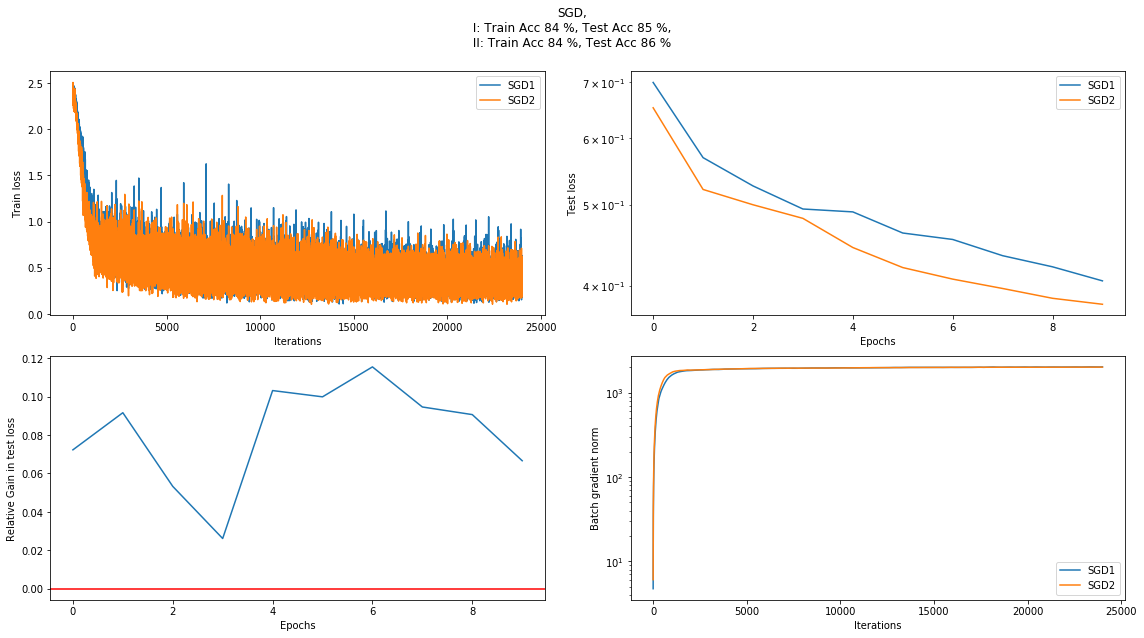

In [0]:
loss_train1, loss_test1, bgradients1, final_train_accuracy1, final_test_accuracy1 = CNN_FMNIST_SGD1_training(n_meta_epochs, hs)
loss_train2, loss_test2, bgradients2, final_train_accuracy2, final_test_accuracy2 = CNN_FMNIST_SGD2_training(n_meta_epochs, hs)

name = 'SGD'
plot_metrics_net(loss_train1, loss_train2,
                loss_test1, loss_test2,
                bgradients1, bgradients2, h,
                name, final_train_accuracy1, final_test_accuracy1,
                            final_train_accuracy2, final_test_accuracy2)

In [0]:
# Systematic experiments:
av_l1 = []
av_l2 = []

ftr1 = []
ftr2 = []

fte1 = []
fte2 = []

n_exp = 50
for exp in range(n_exp):
  print('EXPERIMENT # ', exp)
  
  # Download and load the training data
  trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True)
  X_train = trainset.train_data.to(dtype=torch.float)/255
  y_train = trainset.train_labels
  X_train.resize_(len(X_train), 1, *X_train[0].shape)
  y_train.view(-1).long()

  shuffling = torch.randperm(len(y_train))
  X_train = X_train[shuffling]
  y_train = y_train[shuffling]

  # Download and load the test data
  testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False)
  X_test = testset.test_data.to(dtype=torch.float)/255
  y_test = testset.test_labels
  X_test.resize_(len(X_test), 1, *X_test[0].shape)
  y_test.view(-1).long()

  shuffling = torch.randperm(len(y_test))
  X_test = X_test[shuffling].cuda()
  y_test = y_test[shuffling]

  N_train = int(len(y_train)/(len(y_train) + len(y_test))*N)   # Number of training batches
  N_test  = int(len(y_test)/(len(y_train)  + len(y_test))*N)    # Number of test batches
  s_train = b*N_train                             # Number of training points
  s_test  = b*N_test                              # Number of test points

  Xs      = torch.zeros((N_train,b,*X_train[0].shape),requires_grad=False).cuda()
  ys      = torch.zeros((N_train,b),requires_grad=False, dtype=torch.int64).cuda()

  for i in range(N_train):
      Xs[i] = X_train[b*i:b*(i+1), :]
      ys[i] = y_train[b*i:b*(i+1)]
  
  loss_train1, loss_test1, bgradients1, final_train_accuracy1, final_test_accuracy1 = CNN_FMNIST_SGD1_training(n_meta_epochs, hs)
  loss_train2, loss_test2, bgradients2, final_train_accuracy2, final_test_accuracy2 = CNN_FMNIST_SGD2_training(n_meta_epochs, hs)
  
  average_test_loss1 = torch.mean(torch.tensor(loss_test1[-4:]))
  average_test_loss2 = torch.mean(torch.tensor(loss_test2[-4:]))
  
  av_l1.append(average_test_loss1)
  av_l2.append(average_test_loss2)
  
  ftr1.append(final_train_accuracy1)
  ftr2.append(final_train_accuracy2)
  
  fte1.append(final_test_accuracy1)
  fte2.append(final_test_accuracy2)

EXPERIMENT #  0


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")

100%|██████████| 10/10 [01:27<00:00,  8.74s/it]

100%|██████████| 10/10 [01:43<00:00,  9.38s/it]


EXPERIMENT #  1



100%|██████████| 10/10 [01:26<00:00,  8.69s/it]

100%|██████████| 10/10 [01:27<00:00,  8.75s/it]


EXPERIMENT #  2



100%|██████████| 10/10 [01:27<00:00,  8.77s/it]

100%|██████████| 10/10 [02:21<00:00, 16.23s/it]


EXPERIMENT #  3



100%|██████████| 10/10 [02:50<00:00, 17.07s/it]

100%|██████████| 10/10 [01:59<00:00,  9.87s/it]


EXPERIMENT #  4



100%|██████████| 10/10 [01:27<00:00,  8.74s/it]

100%|██████████| 10/10 [01:27<00:00,  8.81s/it]


EXPERIMENT #  5



100%|██████████| 10/10 [01:27<00:00,  8.75s/it]

100%|██████████| 10/10 [01:27<00:00,  8.71s/it]


EXPERIMENT #  6



100%|██████████| 10/10 [01:27<00:00,  8.73s/it]

100%|██████████| 10/10 [01:27<00:00,  8.69s/it]


EXPERIMENT #  7



100%|██████████| 10/10 [01:26<00:00,  8.67s/it]

100%|██████████| 10/10 [01:27<00:00,  8.71s/it]


EXPERIMENT #  8



100%|██████████| 10/10 [01:27<00:00,  8.80s/it]

100%|██████████| 10/10 [01:27<00:00,  8.69s/it]


EXPERIMENT #  9



100%|██████████| 10/10 [01:28<00:00,  9.04s/it]

100%|██████████| 10/10 [02:43<00:00, 16.73s/it]


EXPERIMENT #  10



100%|██████████| 10/10 [02:00<00:00, 11.52s/it]

100%|██████████| 10/10 [02:54<00:00, 17.45s/it]


EXPERIMENT #  11



100%|██████████| 10/10 [01:40<00:00,  9.18s/it]

100%|██████████| 10/10 [02:33<00:00, 16.89s/it]


EXPERIMENT #  12



100%|██████████| 10/10 [02:08<00:00, 10.09s/it]

100%|██████████| 10/10 [01:27<00:00,  8.79s/it]


EXPERIMENT #  13



100%|██████████| 10/10 [01:27<00:00,  8.75s/it]

100%|██████████| 10/10 [01:27<00:00,  8.75s/it]


EXPERIMENT #  14



100%|██████████| 10/10 [01:27<00:00,  8.73s/it]

100%|██████████| 10/10 [01:27<00:00,  8.76s/it]


EXPERIMENT #  15



100%|██████████| 10/10 [01:27<00:00,  8.83s/it]

100%|██████████| 10/10 [01:27<00:00,  8.79s/it]


EXPERIMENT #  16



100%|██████████| 10/10 [01:27<00:00,  8.80s/it]

100%|██████████| 10/10 [01:27<00:00,  8.76s/it]


EXPERIMENT #  17



100%|██████████| 10/10 [01:27<00:00,  8.77s/it]

100%|██████████| 10/10 [01:27<00:00,  8.76s/it]


EXPERIMENT #  18



100%|██████████| 10/10 [01:27<00:00,  8.76s/it]

100%|██████████| 10/10 [01:27<00:00,  8.82s/it]


EXPERIMENT #  19



100%|██████████| 10/10 [01:27<00:00,  8.76s/it]

100%|██████████| 10/10 [01:27<00:00,  8.79s/it]


EXPERIMENT #  20



100%|██████████| 10/10 [01:27<00:00,  8.75s/it]

100%|██████████| 10/10 [01:27<00:00,  8.77s/it]


EXPERIMENT #  21



100%|██████████| 10/10 [01:27<00:00,  8.78s/it]

100%|██████████| 10/10 [01:28<00:00,  8.79s/it]


EXPERIMENT #  22



100%|██████████| 10/10 [01:27<00:00,  8.80s/it]

100%|██████████| 10/10 [01:28<00:00,  8.78s/it]


EXPERIMENT #  23



100%|██████████| 10/10 [01:27<00:00,  8.80s/it]

100%|██████████| 10/10 [01:27<00:00,  8.74s/it]


EXPERIMENT #  24



100%|██████████| 10/10 [01:27<00:00,  8.79s/it]

100%|██████████| 10/10 [01:27<00:00,  8.77s/it]


EXPERIMENT #  25



100%|██████████| 10/10 [01:27<00:00,  8.79s/it]

100%|██████████| 10/10 [01:27<00:00,  8.77s/it]


EXPERIMENT #  26



100%|██████████| 10/10 [01:28<00:00,  8.79s/it]

100%|██████████| 10/10 [01:27<00:00,  8.79s/it]


EXPERIMENT #  27



100%|██████████| 10/10 [01:27<00:00,  8.76s/it]

100%|██████████| 10/10 [01:27<00:00,  8.77s/it]


EXPERIMENT #  28



100%|██████████| 10/10 [01:27<00:00,  8.73s/it]

100%|██████████| 10/10 [01:27<00:00,  8.74s/it]


EXPERIMENT #  29



100%|██████████| 10/10 [01:27<00:00,  8.75s/it]

100%|██████████| 10/10 [01:27<00:00,  8.75s/it]


EXPERIMENT #  30



100%|██████████| 10/10 [01:27<00:00,  8.75s/it]

100%|██████████| 10/10 [01:27<00:00,  8.76s/it]


EXPERIMENT #  31



100%|██████████| 10/10 [01:28<00:00,  8.80s/it]

100%|██████████| 10/10 [01:27<00:00,  8.75s/it]


EXPERIMENT #  32



100%|██████████| 10/10 [01:27<00:00,  8.78s/it]

100%|██████████| 10/10 [01:27<00:00,  8.77s/it]


EXPERIMENT #  33



100%|██████████| 10/10 [01:28<00:00,  8.78s/it]

100%|██████████| 10/10 [01:27<00:00,  8.74s/it]


EXPERIMENT #  34



100%|██████████| 10/10 [01:27<00:00,  8.73s/it]

100%|██████████| 10/10 [01:27<00:00,  8.81s/it]


EXPERIMENT #  35



100%|██████████| 10/10 [01:27<00:00,  8.76s/it]

100%|██████████| 10/10 [01:27<00:00,  8.79s/it]


EXPERIMENT #  36



100%|██████████| 10/10 [01:27<00:00,  8.76s/it]

100%|██████████| 10/10 [01:28<00:00,  8.81s/it]


EXPERIMENT #  37



100%|██████████| 10/10 [01:27<00:00,  8.80s/it]

100%|██████████| 10/10 [01:27<00:00,  8.78s/it]


EXPERIMENT #  38



100%|██████████| 10/10 [01:28<00:00,  8.83s/it]

100%|██████████| 10/10 [01:27<00:00,  8.79s/it]


EXPERIMENT #  39



100%|██████████| 10/10 [01:28<00:00,  8.80s/it]

100%|██████████| 10/10 [01:27<00:00,  8.77s/it]


EXPERIMENT #  40



100%|██████████| 10/10 [01:27<00:00,  8.76s/it]

100%|██████████| 10/10 [01:27<00:00,  8.78s/it]


EXPERIMENT #  41



100%|██████████| 10/10 [01:27<00:00,  8.76s/it]

100%|██████████| 10/10 [01:28<00:00,  8.83s/it]


EXPERIMENT #  42



100%|██████████| 10/10 [01:27<00:00,  8.81s/it]

100%|██████████| 10/10 [01:27<00:00,  8.77s/it]


EXPERIMENT #  43



100%|██████████| 10/10 [01:27<00:00,  8.76s/it]

100%|██████████| 10/10 [01:27<00:00,  8.77s/it]


EXPERIMENT #  44



100%|██████████| 10/10 [01:27<00:00,  8.76s/it]

100%|██████████| 10/10 [01:27<00:00,  8.75s/it]


EXPERIMENT #  45



100%|██████████| 10/10 [01:27<00:00,  8.84s/it]

 10%|█         | 1/10 [00:08<01:18,  8.68s/it]

KeyboardInterrupt: ignored

In [0]:
print('Test accuracy SGD1 (%.2f +- %.2f)%%'%( 100*torch.mean(torch.tensor(fte1)), 100*torch.std(torch.tensor(fte1))))
print('Test accuracy SGD2 (%.2f +- %.2f)%%'%( 100*torch.mean(torch.tensor(fte2)), 100*torch.std(torch.tensor(fte2))))

print('Train accuracy SGD1 (%.2f +- %.2f)%%'%( 100*torch.mean(torch.tensor(ftr1)), 100*torch.std(torch.tensor(ftr1))))
print('Train accuracy SGD2 (%.2f +- %.2f)%%'%( 100*torch.mean(torch.tensor(ftr2)), 100*torch.std(torch.tensor(ftr2))))

print('Test loss SGD1 (%.3f +- %.3f)'%( torch.mean(torch.tensor(av_l1)), torch.std(torch.tensor(av_l1))))
print('Test loss SGD2 (%.3f +- %.3f)'%( torch.mean(torch.tensor(av_l2)), torch.std(torch.tensor(av_l2))))

Test accuracy SGD1 (86.16 +- 0.55)%
Test accuracy SGD2 (86.16 +- 0.41)%
Train accuracy SGD1 (86.04 +- 4.85)%
Train accuracy SGD2 (87.60 +- 4.52)%
Test loss SGD1 (0.402 +- 0.012)
Test loss SGD2 (0.401 +- 0.010)


## SAG

In [0]:
import torch 
import numpy as np
# torch.cuda.set_device(0)
print('Working on GPU ',torch.cuda.current_device())
import torch.nn as nn
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
# from matplotlib.pyplot import *
%matplotlib inline
from tqdm import tqdm

n = 784
s = 70000

b = 50   # batch size
N = 1400   # total number of batches. should be equal to the s/b
h = 0.001  # step size
n_meta_epochs = 30
hs = np.array([h for i in range(n_meta_epochs)])#*np.linspace(1,0.00001, n_meta_epochs)

# Download and load the training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True)
X_train = trainset.train_data.to(dtype=torch.float)/255
y_train = trainset.train_labels
X_train.resize_(len(X_train), 1, *X_train[0].shape)
y_train.view(-1).long()

shuffling = torch.randperm(len(y_train))
X_train = X_train[shuffling]
y_train = y_train[shuffling]

# Download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False)
X_test = testset.test_data.to(dtype=torch.float)/255
y_test = testset.test_labels
X_test.resize_(len(X_test), 1, *X_test[0].shape)
y_test.view(-1).long()

shuffling = torch.randperm(len(y_test))
X_test = X_test[shuffling].cuda()
y_test = y_test[shuffling]

N_train = int(len(y_train)/(len(y_train) + len(y_test))*N)   # Number of training batches
N_test  = int(len(y_test)/(len(y_train)  + len(y_test))*N)    # Number of test batches
s_train = b*N_train                             # Number of training points
s_test  = b*N_test                              # Number of test points

Xs      = torch.zeros((N_train,b,*X_train[0].shape),requires_grad=False).cuda()
ys      = torch.zeros((N_train,b),requires_grad=False, dtype=torch.int64).cuda()

for i in range(N_train):
    Xs[i] = X_train[b*i:b*(i+1), :]
    ys[i] = y_train[b*i:b*(i+1)]
    
def CNN_FMNIST_SAG1_training(n_meta_epochs, hs):
  class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
  #instance of the Conv Net
  cnn = CNN().cuda();
  
  v_hist  = []
  av_grad = []
  # SAG initialization for each parameter
  for parameter in cnn.parameters():
    v_hist.append(torch.zeros((N_train,*parameter.shape),requires_grad=False))
    av_grad.append(torch.zeros(*parameter.shape ,requires_grad=False))
    
  #loss function and optimizer
  criterion = nn.CrossEntropyLoss();

  loss_train1  = []
  loss_test1  = []
  bgradients1 = []

  for j in tqdm(range(n_meta_epochs)):
      for i in range(N_train):
          Xs[i] = Xs[i].cuda()
          pred = cnn.forward(Xs[i])
          loss = criterion(pred, ys[i])
          loss.backward()
          bgradients1.append(torch.nn.utils.clip_grad_norm_(cnn.parameters(), 1))

          # Gradient step
          for idp, parameter in enumerate(cnn.parameters()):
              av_grad[idp]   = av_grad[idp] - v_hist[idp][i]
              v_hist[idp][i] = b*parameter.grad.data
              av_grad[idp]   = av_grad[idp] + v_hist[idp][i]
              grad           = (1/s_train)*av_grad[idp]
              grad           = grad.cuda()
              parameter.data = parameter.data - h*grad

          loss_train1.append(loss.data)

      for i in range(N_train):
          pred = cnn.forward(Xs[i])
          loss = criterion(pred, ys[i])
          loss.backward()
          bgradients1.append(torch.nn.utils.clip_grad_norm_(cnn.parameters(), 1))

          # Gradient step
          for idp, parameter in enumerate(cnn.parameters()):
              av_grad[idp]   = av_grad[idp] - v_hist[idp][i]
              v_hist[idp][i] = b*parameter.grad.data
              av_grad[idp]   = av_grad[idp] + v_hist[idp][i]
              grad           = (1/s_train)*av_grad[idp]
              grad           = grad.cuda()
              parameter.data = parameter.data - h*grad

          loss_train1.append(loss.data)

      if j == n_meta_epochs - 1:
        pred_label = torch.max(pred, 1, keepdim=True)[1]
        final_train_accuracy1 = pred_label.eq(ys[i].data.view_as(pred_label)).sum().to(dtype=torch.float)/len(ys[i])

      with torch.no_grad():
          Xst = X_test.cuda()
          Xst = Xst.cuda()
          yst = y_test.cuda()
          yst = yst.cuda()
          pred = cnn.forward(Xst)
          loss = criterion(pred, yst)
          loss_test1.append(loss.data)
        
          if j == n_meta_epochs - 1:
            pred_label = torch.max(pred, 1, keepdim=True)[1]
            final_test_accuracy1 = pred_label.eq(yst.data.view_as(pred_label)).sum().to(dtype=torch.float)/len(yst)
  return loss_train1, loss_test1, bgradients1, final_train_accuracy1.data, final_test_accuracy1.data

def CNN_FMNIST_SAG2_training(n_meta_epochs, hs): 
  class CNN(nn.Module):
      def __init__(self):
          super(CNN, self).__init__()
          self.layer1 = nn.Sequential(
              nn.Conv2d(1, 16, kernel_size=5, padding=2),
              nn.BatchNorm2d(16),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2))
          self.layer2 = nn.Sequential(
              nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
              nn.BatchNorm2d(32),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2))
          self.fc = nn.Linear(7*7*32, 10)

      def forward(self, x):
          out = self.layer1(x)
          out = self.layer2(out)
          out = out.view(out.size(0), -1)
          out = self.fc(out)
          return out

  #instance of the Conv Net
  cnn = CNN().cuda();
  
  v_hist  = []
  av_grad = []
  # SAG initialization for each parameter
  for parameter in cnn.parameters():
    v_hist.append(torch.zeros((N_train,*parameter.shape),requires_grad=False))
    av_grad.append(torch.zeros(*parameter.shape, requires_grad=False))
    
  #loss function and optimizer
  criterion = nn.CrossEntropyLoss();

  loss_train2  = []
  loss_test2  = []
  bgradients2 = []

  for j in tqdm(range(n_meta_epochs)):
      for i in range(N_train):
          Xs[i] = Xs[i].cuda()
          pred = cnn.forward(Xs[i])
          loss = criterion(pred, ys[i])
          loss.backward()
          bgradients2.append(torch.nn.utils.clip_grad_norm_(cnn.parameters(), 1))

          # Gradient step
          for idp, parameter in enumerate(cnn.parameters()):
              av_grad[idp]   = av_grad[idp] - v_hist[idp][i]
              v_hist[idp][i] = b*parameter.grad.data
              av_grad[idp]   = av_grad[idp] + v_hist[idp][i]
              grad           = (1/s_train)*av_grad[idp]
              grad           = grad.cuda()
              parameter.data = parameter.data - h*grad

          loss_train2.append(loss.data)
          

      for k in range(N_train):
          i = N_train-(k+1)
          pred = cnn.forward(Xs[i])
          loss = criterion(pred, ys[i])
          loss.backward()
          bgradients2.append(torch.nn.utils.clip_grad_norm_(cnn.parameters(), 1))

          # Gradient step
          for idp, parameter in enumerate(cnn.parameters()):
              av_grad[idp]   = av_grad[idp] - v_hist[idp][i]
              v_hist[idp][i] = b*parameter.grad.data
              av_grad[idp]   = av_grad[idp] + v_hist[idp][i]
              grad           = (1/s_train)*av_grad[idp]
              grad           = grad.cuda()
              parameter.data = parameter.data - h*grad

          loss_train2.append(loss.data)
        
      if j == n_meta_epochs - 1:
        pred_label = torch.max(pred, 1, keepdim=True)[1]
        final_train_accuracy2 = pred_label.eq(ys[i].data.view_as(pred_label)).sum().to(dtype=torch.float)/len(ys[i])

      with torch.no_grad():
          Xst = X_test.cuda()
          Xst = Xst.cuda()
          yst = y_test.cuda()
          yst = yst.cuda()
          pred = cnn.forward(Xst)
          loss = criterion(pred, yst)
          loss_test2.append(loss.data)

          if j == n_meta_epochs - 1:
            pred_label = torch.max(pred, 1, keepdim=True)[1]
            final_test_accuracy2 = pred_label.eq(yst.data.view_as(pred_label)).sum().to(dtype=torch.float)/len(yst)
  
  return loss_train2, loss_test2, bgradients2, final_train_accuracy2.data, final_test_accuracy2.data

Working on GPU  0


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [0]:
loss_train1, loss_test1, bgradients1, final_train_accuracy1, final_test_accuracy1 = CNN_FMNIST_SAG1_training(n_meta_epochs, hs)
loss_train2, loss_test2, bgradients2, final_train_accuracy2, final_test_accuracy2 = CNN_FMNIST_SAG2_training(n_meta_epochs, hs)

name = 'SAG'
plot_metrics_net(loss_train1, loss_train2,
                loss_test1, loss_test2,
                bgradients1, bgradients2, h,
                name, final_train_accuracy1, final_test_accuracy1,
                            final_train_accuracy2, final_test_accuracy2)

In [0]:
# Systematic experiments:
av_l1 = []
av_l2 = []

ftr1 = []
ftr2 = []

fte1 = []
fte2 = []

n_exp = 50
n = 784
s = 70000

b = 50   # batch size
N = 1400   # total number of batches. should be equal to the s/b
h = 0.0001  # step size
n_meta_epochs = 30
hs = np.array([h for i in range(n_meta_epochs)])#*np.linspace(1,0.00001, n_meta_epochs)
for exp in range(n_exp):
  print('EXPERIMENT # ', exp)
  
  # Download and load the training data
  trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True)
  X_train = trainset.train_data.to(dtype=torch.float)/255
  y_train = trainset.train_labels
  X_train.resize_(len(X_train), 1, *X_train[0].shape)
  y_train.view(-1).long()

  shuffling = torch.randperm(len(y_train))
  X_train = X_train[shuffling]
  y_train = y_train[shuffling]

  # Download and load the test data
  testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False)
  X_test = testset.test_data.to(dtype=torch.float)/255
  y_test = testset.test_labels
  X_test.resize_(len(X_test), 1, *X_test[0].shape)
  y_test.view(-1).long()

  shuffling = torch.randperm(len(y_test))
  X_test = X_test[shuffling].cuda()
  y_test = y_test[shuffling]

  N_train = int(len(y_train)/(len(y_train) + len(y_test))*N)   # Number of training batches
  N_test  = int(len(y_test)/(len(y_train)  + len(y_test))*N)    # Number of test batches
  s_train = b*N_train                             # Number of training points
  s_test  = b*N_test                              # Number of test points

  Xs      = torch.zeros((N_train,b,*X_train[0].shape),requires_grad=False).cuda()
  ys      = torch.zeros((N_train,b),requires_grad=False, dtype=torch.int64).cuda()

  for i in range(N_train):
      Xs[i] = X_train[b*i:b*(i+1), :]
      ys[i] = y_train[b*i:b*(i+1)]
  
  loss_train1, loss_test1, bgradients1, final_train_accuracy1, final_test_accuracy1 = CNN_FMNIST_SAG1_training(n_meta_epochs, hs)
  loss_train2, loss_test2, bgradients2, final_train_accuracy2, final_test_accuracy2 = CNN_FMNIST_SAG2_training(n_meta_epochs, hs)
  
  average_test_loss1 = torch.mean(torch.tensor(loss_test1[-4:]))
  average_test_loss2 = torch.mean(torch.tensor(loss_test2[-4:]))
  
  av_l1.append(average_test_loss1)
  av_l2.append(average_test_loss2)
  
  ftr1.append(final_train_accuracy1)
  ftr2.append(final_train_accuracy2)
  
  fte1.append(final_test_accuracy1)
  fte2.append(final_test_accuracy2)

EXPERIMENT #  0


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")



  0%|          | 0/30 [00:00<?, ?it/s]


  3%|▎         | 1/30 [00:17<08:14, 17.07s/it]


  7%|▋         | 2/30 [00:33<07:51, 16.84s/it]


 10%|█         | 3/30 [00:49<07:28, 16.62s/it]


 13%|█▎        | 4/30 [01:06<07:12, 16.65s/it]


 17%|█▋        | 5/30 [01:22<06:51, 16.46s/it]


 20%|██    

EXPERIMENT #  1





  0%|          | 0/30 [00:00<?, ?it/s]


  3%|▎         | 1/30 [00:16<07:57, 16.46s/it]


  7%|▋         | 2/30 [00:32<07:41, 16.47s/it]


 10%|█         | 3/30 [00:49<07:25, 16.50s/it]


 13%|█▎        | 4/30 [01:06<07:10, 16.55s/it]


 17%|█▋        | 5/30 [01:22<06:51, 16.47s/it]


 20%|██        | 6/30 [01:39<06:36, 16.50s/it]


 23%|██▎       | 7/30 [01:55<06:22, 16.61s/it]


 27%|██▋       | 8/30 [02:11<06:01, 16.42s/it]


 30%|███       | 9/30 [02:28<05:44, 16.38s/it]


 33%|███▎      | 10/30 [02:44<05:30, 16.51s/it]


 37%|███▋      | 11/30 [03:00<05:10, 16.32s/it]


 40%|████      | 12/30 [03:17<04:53, 16.30s/it]


 43%|████▎     | 13/30 [03:33<04:37, 16.32s/it]


 47%|████▋     | 14/30 [03:49<04:19, 16.24s/it]


 50%|█████     | 15/30 [04:05<04:04, 16.27s/it]


 53%|█████▎    | 16/30 [04:22<03:49, 16.37s/it]


 57%|█████▋    | 17/30 [04:38<03:31, 16.31s/it]


 60%|██████    | 18/30 [04:55<03:16, 16.35s/it]


 63%|██████▎   | 19/30 [05:11<03:00, 16.43s/it]


 67%|██████▋   

EXPERIMENT #  2





  0%|          | 0/30 [00:00<?, ?it/s]


  3%|▎         | 1/30 [00:16<07:59, 16.53s/it]


  7%|▋         | 2/30 [00:32<07:41, 16.47s/it]


 10%|█         | 3/30 [00:49<07:24, 16.46s/it]


 13%|█▎        | 4/30 [01:05<07:06, 16.42s/it]


 17%|█▋        | 5/30 [01:21<06:46, 16.27s/it]


 20%|██        | 6/30 [01:37<06:29, 16.22s/it]


 23%|██▎       | 7/30 [01:54<06:16, 16.36s/it]


 27%|██▋       | 8/30 [02:10<05:56, 16.22s/it]


 30%|███       | 9/30 [02:26<05:39, 16.17s/it]


 33%|███▎      | 10/30 [02:42<05:25, 16.28s/it]


 37%|███▋      | 11/30 [02:58<05:08, 16.25s/it]


 40%|████      | 12/30 [03:15<04:52, 16.24s/it]


 43%|████▎     | 13/30 [03:31<04:37, 16.30s/it]


 47%|████▋     | 14/30 [03:47<04:20, 16.29s/it]


 50%|█████     | 15/30 [04:03<04:02, 16.18s/it]


 53%|█████▎    | 16/30 [04:20<03:46, 16.19s/it]


 57%|█████▋    | 17/30 [04:35<03:29, 16.10s/it]


 60%|██████    | 18/30 [04:51<03:12, 16.07s/it]


 63%|██████▎   | 19/30 [05:08<02:57, 16.16s/it]


 67%|██████▋   

EXPERIMENT #  3





  0%|          | 0/30 [00:00<?, ?it/s]


  3%|▎         | 1/30 [00:16<07:52, 16.31s/it]


  7%|▋         | 2/30 [00:32<07:34, 16.25s/it]


 10%|█         | 3/30 [00:48<07:17, 16.20s/it]


 13%|█▎        | 4/30 [01:04<07:01, 16.21s/it]


 17%|█▋        | 5/30 [01:20<06:42, 16.11s/it]


 20%|██        | 6/30 [01:36<06:26, 16.08s/it]


 23%|██▎       | 7/30 [01:53<06:13, 16.25s/it]


 27%|██▋       | 8/30 [02:09<05:57, 16.25s/it]


 30%|███       | 9/30 [02:25<05:41, 16.25s/it]


 33%|███▎      | 10/30 [02:42<05:27, 16.37s/it]


 37%|███▋      | 11/30 [02:58<05:09, 16.28s/it]


 40%|████      | 12/30 [03:14<04:52, 16.23s/it]


 43%|████▎     | 13/30 [03:30<04:36, 16.24s/it]


 47%|████▋     | 14/30 [03:46<04:17, 16.09s/it]


 50%|█████     | 15/30 [04:02<04:00, 16.02s/it]


 53%|█████▎    | 16/30 [04:19<03:47, 16.25s/it]


 57%|█████▋    | 17/30 [04:35<03:31, 16.27s/it]


 60%|██████    | 18/30 [04:51<03:15, 16.31s/it]


 63%|██████▎   | 19/30 [05:08<02:59, 16.29s/it]


 67%|██████▋   

EXPERIMENT #  4





  0%|          | 0/30 [00:00<?, ?it/s]


  3%|▎         | 1/30 [00:16<07:59, 16.55s/it]


  7%|▋         | 2/30 [00:32<07:41, 16.48s/it]


 10%|█         | 3/30 [00:49<07:23, 16.42s/it]


 13%|█▎        | 4/30 [01:05<07:07, 16.43s/it]


 17%|█▋        | 5/30 [01:21<06:46, 16.25s/it]


 20%|██        | 6/30 [01:37<06:28, 16.17s/it]


 23%|██▎       | 7/30 [01:53<06:10, 16.11s/it]


 27%|██▋       | 8/30 [02:09<05:52, 16.01s/it]


 30%|███       | 9/30 [02:25<05:35, 15.98s/it]


 33%|███▎      | 10/30 [02:41<05:23, 16.20s/it]


 37%|███▋      | 11/30 [02:57<05:06, 16.12s/it]


 40%|████      | 12/30 [03:13<04:49, 16.10s/it]


 43%|████▎     | 13/30 [03:30<04:35, 16.18s/it]


 47%|████▋     | 14/30 [03:46<04:19, 16.23s/it]


 50%|█████     | 15/30 [04:02<04:03, 16.21s/it]


 53%|█████▎    | 16/30 [04:18<03:47, 16.24s/it]


 57%|█████▋    | 17/30 [04:34<03:30, 16.16s/it]


 60%|██████    | 18/30 [04:50<03:13, 16.13s/it]


 63%|██████▎   | 19/30 [05:07<02:58, 16.27s/it]


 67%|██████▋   

EXPERIMENT #  5





  0%|          | 0/30 [00:00<?, ?it/s]


  3%|▎         | 1/30 [00:16<07:59, 16.52s/it]


  7%|▋         | 2/30 [00:32<07:36, 16.29s/it]


 10%|█         | 3/30 [00:48<07:16, 16.18s/it]


 13%|█▎        | 4/30 [01:04<07:00, 16.16s/it]


 17%|█▋        | 5/30 [01:20<06:40, 16.04s/it]


 20%|██        | 6/30 [01:36<06:24, 16.02s/it]


 23%|██▎       | 7/30 [01:52<06:12, 16.22s/it]


 27%|██▋       | 8/30 [02:08<05:55, 16.15s/it]


 30%|███       | 9/30 [02:24<05:38, 16.11s/it]


 33%|███▎      | 10/30 [02:41<05:24, 16.21s/it]


 37%|███▋      | 11/30 [02:57<05:08, 16.22s/it]


 40%|████      | 12/30 [03:13<04:51, 16.22s/it]


 43%|████▎     | 13/30 [03:29<04:35, 16.22s/it]


 47%|████▋     | 14/30 [03:45<04:18, 16.13s/it]


 50%|█████     | 15/30 [04:01<04:01, 16.13s/it]


 53%|█████▎    | 16/30 [04:18<03:46, 16.21s/it]


 57%|█████▋    | 17/30 [04:34<03:29, 16.14s/it]


 60%|██████    | 18/30 [04:50<03:13, 16.10s/it]


 63%|██████▎   | 19/30 [05:06<02:57, 16.13s/it]


 67%|██████▋   

EXPERIMENT #  6





  0%|          | 0/30 [00:00<?, ?it/s]


  3%|▎         | 1/30 [00:16<07:56, 16.44s/it]


  7%|▋         | 2/30 [00:32<07:36, 16.31s/it]


 10%|█         | 3/30 [00:48<07:18, 16.24s/it]


 13%|█▎        | 4/30 [01:05<07:06, 16.39s/it]


 17%|█▋        | 5/30 [01:21<06:48, 16.35s/it]


 20%|██        | 6/30 [01:37<06:31, 16.33s/it]


 23%|██▎       | 7/30 [01:54<06:17, 16.43s/it]


 27%|██▋       | 8/30 [02:10<05:59, 16.33s/it]


 30%|███       | 9/30 [02:26<05:42, 16.30s/it]


 33%|███▎      | 10/30 [02:43<05:25, 16.29s/it]


 37%|███▋      | 11/30 [02:58<05:05, 16.08s/it]


 40%|████      | 12/30 [03:14<04:48, 16.04s/it]


 43%|████▎     | 13/30 [03:31<04:35, 16.22s/it]


 47%|████▋     | 14/30 [03:47<04:19, 16.24s/it]


 50%|█████     | 15/30 [04:03<04:03, 16.25s/it]


 53%|█████▎    | 16/30 [04:19<03:46, 16.21s/it]


 57%|█████▋    | 17/30 [04:35<03:29, 16.08s/it]


 60%|██████    | 18/30 [04:51<03:12, 16.05s/it]


 63%|██████▎   | 19/30 [05:08<02:58, 16.23s/it]


 67%|██████▋   

EXPERIMENT #  7





  0%|          | 0/30 [00:00<?, ?it/s]


  3%|▎         | 1/30 [00:16<08:02, 16.64s/it]


  7%|▋         | 2/30 [00:33<07:43, 16.56s/it]


 10%|█         | 3/30 [00:49<07:25, 16.51s/it]


 13%|█▎        | 4/30 [01:06<07:12, 16.65s/it]


 17%|█▋        | 5/30 [01:22<06:54, 16.58s/it]


 20%|██        | 6/30 [01:39<06:39, 16.64s/it]


 23%|██▎       | 7/30 [01:56<06:21, 16.60s/it]


 27%|██▋       | 8/30 [02:12<06:02, 16.47s/it]


 30%|███       | 9/30 [02:28<05:43, 16.38s/it]


 33%|███▎      | 10/30 [02:45<05:30, 16.52s/it]


 37%|███▋      | 11/30 [03:01<05:12, 16.44s/it]


 40%|████      | 12/30 [03:17<04:54, 16.39s/it]


 43%|████▎     | 13/30 [03:34<04:39, 16.43s/it]


 47%|████▋     | 14/30 [03:50<04:21, 16.33s/it]


 50%|█████     | 15/30 [04:06<04:03, 16.26s/it]


 53%|█████▎    | 16/30 [04:22<03:48, 16.31s/it]


 57%|█████▋    | 17/30 [04:38<03:30, 16.21s/it]


 60%|██████    | 18/30 [04:55<03:14, 16.18s/it]


 63%|██████▎   | 19/30 [05:11<02:59, 16.34s/it]


 67%|██████▋   

EXPERIMENT #  8





  0%|          | 0/30 [00:00<?, ?it/s]


  3%|▎         | 1/30 [00:16<08:02, 16.64s/it]


  7%|▋         | 2/30 [00:32<07:41, 16.48s/it]


 10%|█         | 3/30 [00:49<07:28, 16.62s/it]


 13%|█▎        | 4/30 [01:06<07:13, 16.67s/it]


 17%|█▋        | 5/30 [01:22<06:53, 16.56s/it]


 20%|██        | 6/30 [01:39<06:39, 16.64s/it]


 23%|██▎       | 7/30 [01:56<06:21, 16.59s/it]


 27%|██▋       | 8/30 [02:12<06:02, 16.46s/it]


 30%|███       | 9/30 [02:28<05:47, 16.53s/it]


 33%|███▎      | 10/30 [02:45<05:32, 16.60s/it]


 37%|███▋      | 11/30 [03:01<05:13, 16.50s/it]


 40%|████      | 12/30 [03:18<04:59, 16.62s/it]


 43%|████▎     | 13/30 [03:35<04:43, 16.66s/it]


 47%|████▋     | 14/30 [03:51<04:24, 16.56s/it]


 50%|█████     | 15/30 [04:08<04:09, 16.65s/it]


 53%|█████▎    | 16/30 [04:25<03:53, 16.67s/it]


 57%|█████▋    | 17/30 [04:41<03:35, 16.56s/it]


 60%|██████    | 18/30 [04:58<03:18, 16.53s/it]


 63%|██████▎   | 19/30 [05:14<02:59, 16.35s/it]


 67%|██████▋   

EXPERIMENT #  9





  0%|          | 0/30 [00:00<?, ?it/s]


  3%|▎         | 1/30 [00:16<07:45, 16.04s/it]


  7%|▋         | 2/30 [00:32<07:30, 16.10s/it]


 10%|█         | 3/30 [00:48<07:16, 16.17s/it]


 13%|█▎        | 4/30 [01:04<06:59, 16.12s/it]


 17%|█▋        | 5/30 [01:20<06:42, 16.09s/it]


 20%|██        | 6/30 [01:37<06:30, 16.28s/it]


 23%|██▎       | 7/30 [01:53<06:13, 16.26s/it]


 27%|██▋       | 8/30 [02:09<05:56, 16.21s/it]


 30%|███       | 9/30 [02:26<05:42, 16.32s/it]


 33%|███▎      | 10/30 [02:42<05:23, 16.20s/it]


 37%|███▋      | 11/30 [02:58<05:06, 16.12s/it]


 40%|████      | 12/30 [03:14<04:52, 16.24s/it]


 43%|████▎     | 13/30 [03:30<04:35, 16.21s/it]


 47%|████▋     | 14/30 [03:46<04:19, 16.19s/it]


 50%|█████     | 15/30 [04:03<04:05, 16.39s/it]


 53%|█████▎    | 16/30 [04:19<03:47, 16.21s/it]


 57%|█████▋    | 17/30 [04:35<03:29, 16.15s/it]


 60%|██████    | 18/30 [04:51<03:14, 16.19s/it]


 63%|██████▎   | 19/30 [05:08<02:58, 16.21s/it]


 67%|██████▋   

EXPERIMENT #  10





  0%|          | 0/30 [00:00<?, ?it/s]


  3%|▎         | 1/30 [00:16<07:55, 16.39s/it]


  7%|▋         | 2/30 [00:32<07:40, 16.45s/it]


 10%|█         | 3/30 [00:49<07:20, 16.33s/it]


 13%|█▎        | 4/30 [01:05<07:02, 16.27s/it]


 17%|█▋        | 5/30 [01:21<06:48, 16.34s/it]


 20%|██        | 6/30 [01:37<06:31, 16.29s/it]


 23%|██▎       | 7/30 [01:54<06:14, 16.28s/it]


 27%|██▋       | 8/30 [02:10<06:01, 16.44s/it]


 30%|███       | 9/30 [02:27<05:44, 16.42s/it]


 33%|███▎      | 10/30 [02:43<05:29, 16.46s/it]


 37%|███▋      | 11/30 [03:00<05:16, 16.64s/it]


 40%|████      | 12/30 [03:16<04:56, 16.47s/it]


 43%|████▎     | 13/30 [03:33<04:38, 16.35s/it]


 47%|████▋     | 14/30 [03:49<04:22, 16.38s/it]


 50%|█████     | 15/30 [04:05<04:03, 16.22s/it]


 53%|█████▎    | 16/30 [04:21<03:47, 16.26s/it]


 57%|█████▋    | 17/30 [04:38<03:33, 16.43s/it]


 60%|██████    | 18/30 [04:55<03:17, 16.44s/it]


 63%|██████▎   | 19/30 [05:11<03:00, 16.37s/it]


 67%|██████▋   

EXPERIMENT #  11





  0%|          | 0/30 [00:00<?, ?it/s]


  3%|▎         | 1/30 [00:16<08:07, 16.80s/it]


  7%|▋         | 2/30 [00:33<07:46, 16.68s/it]


 10%|█         | 3/30 [00:49<07:24, 16.46s/it]


 13%|█▎        | 4/30 [01:05<07:09, 16.51s/it]


 17%|█▋        | 5/30 [01:22<06:53, 16.55s/it]


 20%|██        | 6/30 [01:38<06:35, 16.49s/it]


 23%|██▎       | 7/30 [01:55<06:22, 16.63s/it]


 27%|██▋       | 8/30 [02:12<06:07, 16.71s/it]


 30%|███       | 9/30 [02:28<05:47, 16.57s/it]


 33%|███▎      | 10/30 [02:45<05:34, 16.70s/it]


 37%|███▋      | 11/30 [03:02<05:15, 16.61s/it]


 40%|████      | 12/30 [03:18<04:58, 16.59s/it]


 43%|████▎     | 13/30 [03:35<04:43, 16.69s/it]


 47%|████▋     | 14/30 [03:52<04:27, 16.72s/it]


 50%|█████     | 15/30 [04:08<04:08, 16.60s/it]


 53%|█████▎    | 16/30 [04:25<03:51, 16.51s/it]


 57%|█████▋    | 17/30 [04:41<03:32, 16.34s/it]


 60%|██████    | 18/30 [04:56<03:14, 16.19s/it]


 63%|██████▎   | 19/30 [05:12<02:57, 16.11s/it]


 67%|██████▋   

EXPERIMENT #  12





  0%|          | 0/30 [00:00<?, ?it/s]


  3%|▎         | 1/30 [00:16<07:59, 16.55s/it]


  7%|▋         | 2/30 [00:32<07:38, 16.37s/it]


 10%|█         | 3/30 [00:48<07:21, 16.35s/it]


 13%|█▎        | 4/30 [01:05<07:08, 16.47s/it]


 17%|█▋        | 5/30 [01:21<06:50, 16.40s/it]


 20%|██        | 6/30 [01:38<06:33, 16.39s/it]


 23%|██▎       | 7/30 [01:54<06:16, 16.36s/it]


 27%|██▋       | 8/30 [02:10<05:57, 16.24s/it]


 30%|███       | 9/30 [02:26<05:41, 16.26s/it]


 33%|███▎      | 10/30 [02:43<05:26, 16.32s/it]


 37%|███▋      | 11/30 [02:58<05:06, 16.15s/it]


 40%|████      | 12/30 [03:14<04:49, 16.11s/it]


 43%|████▎     | 13/30 [03:31<04:37, 16.30s/it]


 47%|████▋     | 14/30 [03:48<04:21, 16.31s/it]


 50%|█████     | 15/30 [04:04<04:04, 16.31s/it]


 53%|█████▎    | 16/30 [04:21<03:50, 16.44s/it]


 57%|█████▋    | 17/30 [04:37<03:33, 16.39s/it]


 60%|██████    | 18/30 [04:53<03:16, 16.36s/it]


 63%|██████▎   | 19/30 [05:10<03:00, 16.40s/it]


 67%|██████▋   

EXPERIMENT #  13





  0%|          | 0/30 [00:00<?, ?it/s]


  3%|▎         | 1/30 [00:16<08:00, 16.58s/it]


  7%|▋         | 2/30 [00:32<07:39, 16.43s/it]


 10%|█         | 3/30 [00:49<07:27, 16.56s/it]


 13%|█▎        | 4/30 [01:06<07:12, 16.62s/it]


 17%|█▋        | 5/30 [01:22<06:53, 16.55s/it]


 20%|██        | 6/30 [01:39<06:42, 16.76s/it]


 23%|██▎       | 7/30 [01:56<06:25, 16.76s/it]


 27%|██▋       | 8/30 [02:13<06:06, 16.64s/it]


 30%|███       | 9/30 [02:28<05:44, 16.42s/it]


 33%|███▎      | 10/30 [02:44<05:23, 16.19s/it]


 37%|███▋      | 11/30 [03:00<05:04, 16.04s/it]


 40%|████      | 12/30 [03:16<04:48, 16.03s/it]


 43%|████▎     | 13/30 [03:32<04:31, 15.95s/it]


 47%|████▋     | 14/30 [03:48<04:15, 15.97s/it]


 50%|█████     | 15/30 [04:04<04:02, 16.20s/it]


 53%|█████▎    | 16/30 [04:20<03:46, 16.19s/it]


 57%|█████▋    | 17/30 [04:37<03:30, 16.21s/it]


 60%|██████    | 18/30 [04:54<03:16, 16.40s/it]


 63%|██████▎   | 19/30 [05:10<03:00, 16.37s/it]


 67%|██████▋   

In [0]:
print('Test accuracy SAG1 (%.2f +- %.2f)%%'%( 100*torch.mean(torch.tensor(fte1)), 100*torch.std(torch.tensor(fte1))))
print('Test accuracy SAG2 (%.2f +- %.2f)%%'%( 100*torch.mean(torch.tensor(fte2)), 100*torch.std(torch.tensor(fte2))))

print('Train accuracy SAG1 (%.2f +- %.2f)%%'%( 100*torch.mean(torch.tensor(ftr1)), 100*torch.std(torch.tensor(ftr1))))
print('Train accuracy SAG2 (%.2f +- %.2f)%%'%( 100*torch.mean(torch.tensor(ftr2)), 100*torch.std(torch.tensor(ftr2))))

print('Test loss SAG1 (%.3f +- %.3f)'%( torch.mean(torch.tensor(av_l1)), torch.std(torch.tensor(av_l1))))
print('Test loss SAG2 (%.3f +- %.3f)'%( torch.mean(torch.tensor(av_l2)), torch.std(torch.tensor(av_l2))))

NameError: ignored

In [0]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.linalg

def generate_problem(p, N):
  X = np.random.randn(p, N)
  
  # Model definition
  theta_clean = np.ones(p)
  y = X.T@theta_clean + 5e-1*np.random.randn(N) # right-hand side
  theta_0 = np.random.randn(p)
  
  A = X[:, :int(N/2)].T @ X[:, :int(N/2)]
  B = X[:, int(N/2):].T @ X[:, int(N/2):]
  com_norm = np.linalg.norm(A@B - B@A)
  print('Commutator norm (2 batches) {:.3}'.format(com_norm))
  
  return X, theta_0, y

def loss(X, theta, y):
  p, N = X.shape
  return 1/N*np.linalg.norm(X.T@theta - y)**2

def euler_local_problem(X_batch, theta_0, y_batch, h, N, N_precision = 1000):
  p, batch_size = X_batch.shape
  theta = theta_0
  for i in range(N_precision):
    theta = theta + h/N_precision*(-1/N* X_batch@(X_batch.T@theta - y_batch))
    # print(np.linalg.norm(theta))
  return theta

def solve_local_problem(X_batch, theta_0, y_batch, h, N):
  return np.linalg.pinv(X_batch.T) @ (scipy.linalg.expm(-1/N * X_batch.T @ X_batch * h) @ (X_batch.T @ theta_0 - y_batch) + y_batch)

  def gradientflow(problem, steps):
  X, theta_0, y = problem
  p, N = X.shape
  thetas = []
  for h in steps:
    thetas.append(euler_local_problem(X, theta_0, y, h, N, N_precision))
  return thetas

def first_order_splitting(problem, steps, batch_size = 20):
  X, theta_0, y = problem
  p, N = X.shape
  N_batches_per_epoch = int(N / batch_size)
  
  Xs = np.zeros((N_batches_per_epoch,p, batch_size))
  ys = np.zeros((N_batches_per_epoch,batch_size))
  
  for i_batch in range(N_batches_per_epoch):
    Xs[i_batch] = X[:, batch_size*i_batch:batch_size*(i_batch+1)] 
    ys[i_batch] = y[batch_size*i_batch:batch_size*(i_batch+1)]
    
  thetas = []
  for h in steps:
    theta = theta_0
    for i_batch in range(N_batches_per_epoch):
      theta = solve_local_problem(Xs[i_batch], theta, ys[i_batch], h, N)
    thetas.append(theta)
  return thetas

def second_order_splitting(problem, steps, batch_size = 20):
  X, theta_0, y = problem
  p, N = X.shape
  N_batches_per_epoch = int(N / batch_size)
  
  Xs = np.zeros((N_batches_per_epoch,p, batch_size))
  ys = np.zeros((N_batches_per_epoch,batch_size))
  
  for i_batch in range(N_batches_per_epoch):
    Xs[i_batch] = X[:, batch_size*i_batch:batch_size*(i_batch+1)] 
    ys[i_batch] = y[batch_size*i_batch:batch_size*(i_batch+1)]
    
  thetas = []
  for h in steps:
    theta = theta_0
    for i_batch in range(N_batches_per_epoch-1):
      theta = solve_local_problem(Xs[i_batch], theta, ys[i_batch], h/2, N)
    
    i_batch = N_batches_per_epoch - 1
    theta = solve_local_problem(Xs[i_batch], theta, ys[i_batch], h, N)
   
    for k_batch in range(1,N_batches_per_epoch):
      i_batch = N_batches_per_epoch-(k_batch+1)
      theta = solve_local_problem(Xs[i_batch], theta, ys[i_batch], h/2, N)
      
    thetas.append(theta)
  return thetas

  from tqdm import tqdm
trends_1 = np.zeros((50, 20))
trends_2 = np.zeros((50, 20))
precisions = np.logspace(1, 4.1)
i = 0
problem = generate_problem(2, 10)
for precision in tqdm(precisions):
  N_precision = int(precision)
  steps = np.logspace(-2.5, 0, 20)
  batch_size = 2

  thetas_gf = gradientflow(problem, steps)
  thetas_1  = first_order_splitting(problem, steps, batch_size)
  thetas_2  = second_order_splitting(problem, steps, batch_size)

  trends_1[i, :] = [np.linalg.norm(thetas_gf[i] - thetas_1[i]) for i in range(len(thetas_gf))]
  trends_2[i, :] = [np.linalg.norm(thetas_gf[i] - thetas_2[i]) for i in range(len(thetas_gf))]
  i += 1

In [0]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
fig.set_size_inches(10,6)
# Query the figure's on-screen size and DPI. Note that when saving the figure to
# a file, we need to provide a DPI for that separately.
print('fig size: {0} DPI, size in inches {1}'.format(
    fig.get_dpi(), fig.get_size_inches()))

# Plot a scatter that persists (isn't redrawn) and the initial line.
# ax.set_title('Least Squares {} x {}. Batch size {}'.format(*problem[0].shape, batch_size))
ax.set_xlabel('h')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'$\|\theta - \theta_{GF}\|$')


line1, = ax.plot(steps, trends_1[0], 'rx',  label = '1st')
line2, = ax.plot(steps, trends_2[0], 'gx',  label = '2nd')
ax.legend()

def update(i):
    title = 'LS {} x {}. Batch size {}. Euler GF, EXACT splitting # Euler steps {}'.format(*problem[0].shape, batch_size, int(precisions[i]))
    # print(label)
    # Update the line and the axes (with a new xlabel). Return a tuple of
    # "artists" that have to be redrawn for this frame.
    line1.set_data(steps, trends_1[i])
    line2.set_data(steps, trends_2[i])
    ax.set_title(title)
    return (line1, line2), ax


anim = FuncAnimation(fig, update, frames=list(range(len(precisions))), interval=400)  
anim.save('line5.gif', dpi=80, writer='imagemagick')


In [0]:
plt.plot(steps, trend_1, 'rx', label = '1st')
plt.plot(steps, trend_2, 'gx', label = '2nd')
ax.title('Least Squares {} x {}. Batch size {}'.format(*problem[0].shape, batch_size))
ax.xlabel('h')
ax.xscale('log')
ax.yscale('log')
ax.ylabel(r'$\|\theta - \theta_{GF}\|$')
ax.legend()
ax.show()

In [0]:
def gradientflow_stupid(problem, steps):
  A, B, theta_0 = problem
  thetas = []
  for h in steps:
    thetas.append(theta_0@scipy.linalg.expm((A+B)*h))
  return thetas

def first_order_splitting_stupid(problem, steps):
  A, B, theta_0 = problem
  thetas = []
  for h in steps:
    theta = theta_0
    theta = theta@scipy.linalg.expm(A * h)
    theta = theta@scipy.linalg.expm(B * h)
    
    thetas.append(theta)
  return thetas

def second_order_splitting_stupid(problem, steps):
  A, B, theta_0 = problem
  thetas = []
  for h in steps:
    theta = theta_0
    theta = theta@scipy.linalg.expm(A * h/2)
    theta = theta@scipy.linalg.expm(B * h)
    theta = theta@scipy.linalg.expm(A * h/2)
    
    thetas.append(theta)
  return thetas

In [0]:
p = 10
theta_0 = np.random.randn(p)

A = np.random.randn(p, p)
# A, _ = np.linalg.qr(A)
# sv = 0.8**np.arange(p, dtype=float)
# A = A@np.diag(sv)

B = np.random.randn(p, p)
# B, _ = np.linalg.qr(B)
# sv = 0.8**np.arange(p, dtype=float)
# B = B@np.diag(sv)

problem = A, B, theta_0
steps = np.logspace(-5,-2)

thetas_gf = gradientflow_stupid(problem, steps)
thetas_1  = first_order_splitting_stupid(problem, steps)
thetas_2  = second_order_splitting_stupid(problem, steps)

trend_1 = [np.linalg.norm(thetas_gf[i] - thetas_1[i]) for i in range(len(thetas_gf))]
trend_2 = [np.linalg.norm(thetas_gf[i] - thetas_2[i]) for i in range(len(thetas_gf))]

plt.plot(steps, trend_1, 'rx', label = '$e^{(A+B)h} - e^{Ah}e^{Bh}$')
plt.plot(steps, trend_2, 'gx', label = '$e^{(A+B)h} - e^{Ah/2}e^{Bh}e^{Ah/2}$')
plt.title('Stupid random matrix exponent. Commutator norm {:.4}'.format(np.linalg.norm(A@B - B@A)))
plt.xlabel('h')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$\|\theta - \theta_{GF}\|$')
plt.legend()
plt.show()

In [0]:
# Padé approximation
p = 10
A = np.random.randn(p,p)
B = np.random.randn(p,p)
steps = np.logspace(1e-7, 1e-3)

residuals_1 = [np.linalg.norm(scipy.linalg.expm((A+B) * h) - scipy.linalg.expm(A * h)  @scipy.linalg.expm(B * h)) for h in steps]
residuals_2 = [np.linalg.norm(scipy.linalg.expm((A+B) * h) - scipy.linalg.expm(A * h/2)@scipy.linalg.expm(B * h)@scipy.linalg.expm(A * h/2)) for h in steps]
plt.figure(figsize = (10,6))
plt.semilogy(steps, residuals_1, 'rx',label = '$e^{(A+B)h} - e^{Ah}e^{Bh}$')
plt.semilogy(steps, residuals_2, 'gx',label = '$e^{(A+B)h} - e^{Ah/2}e^{Bh}e^{Ah/2}$')
plt.title(r'Random squared matrices A and B. Commutator norm {:.4}'.format(np.linalg.norm(A@B - B@A)))
plt.xlabel('h')
plt.xscale('log')
plt.ylabel('norm of difference')
plt.legend()
plt.show()

In [0]:
# Eigendecomposition
p = 10
A = np.random.randn(p,p)
B = np.random.randn(p,p)
steps = np.linspace(1e-4, 1e-3)

def matrix_exp(A):
  d, Y = np.linalg.eig(A)
  Yinv = np.linalg.pinv(Y)
  D    = np.diag(np.exp(d))

  B = Y@D@Yinv
  return B

residuals_1 = [np.linalg.norm(matrix_exp((A+B) * h) - matrix_exp(A * h)  @matrix_exp(B * h)) for h in steps]
residuals_2 = [np.linalg.norm(matrix_exp((A+B) * h) - matrix_exp(A * h/2)@matrix_exp(B * h)@matrix_exp(A * h/2)) for h in steps]
plt.figure(figsize = (10,6))
plt.semilogy(steps, residuals_1, 'rx',label = '$e^{(A+B)h} - e^{Ah}e^{Bh}$')
plt.semilogy(steps, residuals_2, 'gx',label = '$e^{(A+B)h} - e^{Ah/2}e^{Bh}e^{Ah/2}$')
plt.title(r'Random squared matrices A and B. Commutator norm {:.4}'.format(np.linalg.norm(A@B - B@A)))
plt.xlabel('h')
plt.ylabel('norm of difference')
plt.legend()
plt.show()